# Normalized Vegetation Index (NDVI)

The Normalized Difference Vegetation Index (NDVI) quantifies vegetation by measuring the difference between near-infrared **nir** (which vegetation strongly reflects) and **red** light (which vegetation absorbs). NDVI always ranges from -1 to +1.

* **Negative Values:** It is most likely water.
* **Values Close to 1:** There is a high possibility that they are dense green leaves.
* **Values Close to 0:** There are no green leaves and it could even be an urbanized area.

<img src="resources/ndvi_example.png" alt="Drawing" style="width: 400px;"/>

## Content

1. Undertading Landsat 8 OLI LASRC Scene Data
2. Query Datacube
3. Cloud Masking
4. NDVI Calculation

## Undertading Landsat 8 OLI LASRC Scene Data

The Landsat 8 OLI LASRC scenes taken in this work are images belonging to **Collection 1 - Level 2 (On demand)** of the USGS Earth Explorer image catalog. In particular, Level 2 scenes apply atmospheric corrections called **Surface Reflectance (SR) Correction**. These corrections mitigate the effect of gases and aerosols found in the atmosphere, because gases and aerosols affect the reflectance emited by the earth and read by the satellite (sensor). Atmospheric corrections are carried out in Landsat 8 OLI scenes by the **LASRC (Landsat Surface Reflectance Code) algorithm**.

During the generation of surface reflectance corrected scenes, the LASRC algorithm evaluates the quality of each pixel, the information of this evaluation is recorded in 3 bands (`sr_aerosol`, `pixel_qa`, `radsat_qa`) that are additionally generated at the end of the reflectance correction.

Information on the valid values for each band is found below:

* band_1 (coastal_aerosol): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_2 (blue): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_3 (green): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_4 (red): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_5 (nir): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_6 (swir1): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_7 (swir2): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* pixel_qa (pixel_qa): rango=0,32768 rango_valido=0,32768
* sr_aerosol (sr_aerosol_qa, aerosol_qa, aerosol): rango=0,255; rango_valido=0,255
* radsat_qa (radsat_qa): rango=0,32768 rango_valido=0,32768

#### References

1. [Designación de Bandas para Satelites Landsat](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products)
2. [Evaluación de la Calidad de los Pixeles en Landsat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8-surface-reflectance-quality-assessment?qt-science_support_page_related_con=1#qt-science_support_page_related_con)
3. [Lansat Surface Reflectance Code (LASRC) Product Guide](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf)

Import required Python modules

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import datacube

Retrieve a slice of an scene from the datacube and inspect the resulting **dataset**.

In [2]:
%%time

dc = datacube.Datacube(app="NDVI")

dataset = dc.load(
    # Satellite 
    product="LS8_OLI_LASRC",
    
    # Area to be requested 0.23738925
    latitude=(3.2823060166113676, 4.33496042835),
    longitude=(-70.8429950526129, -69.8153703594),
    #latitude=(3.75702418296, 3.99441343296),
    #longitude=(-70.402981323, -70.166735698),
    # Time format (YYYY-MM-DD)
    # time=("2017-12-21","2017-12-23"),

    # Image spectral bands
    measurements=['red', 'nir','pixel_qa'],
    output_crs='EPSG:4326',
    resolution=(-0.000271302,0.000269995)
)

dataset

CPU times: user 1.54 s, sys: 1.01 s, total: 2.55 s
Wall time: 2.19 s


<xarray.Dataset>
Dimensions:      (latitude: 3881, longitude: 3807, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-13T14:54:23
  * latitude     (latitude) float64 4.335 4.335 4.334 ... 3.283 3.283 3.282
  * longitude    (longitude) float64 -70.84 -70.84 -70.84 ... -69.82 -69.82
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 -9999 -9999 ... -9999 -9999
    nir          (time, latitude, longitude) int16 -9999 -9999 ... -9999 -9999
    pixel_qa     (time, latitude, longitude) int32 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

Ploting the bands of the scene

In [17]:
plt.figure(figsize=(400,600))
fig, axes = plt.subplots(1,2,figsize=(15,5))
# plt.tight_layout()

dataset.red.plot(ax=axes[0])
dataset.nir.plot(ax=axes[1])

<Figure size 28800x43200 with 0 Axes>

Error in callback <function flush_figures at 0x7f8f19cdbe18> (for post_execute):


KeyboardInterrupt: 

Explore every pixel

In [18]:
dataset.red[0][0][0]

<xarray.DataArray 'red' ()>
array(-9999, dtype=int16)
Coordinates:
    time         datetime64[ns] 2020-01-13T14:54:23
    latitude     float64 5.388
    longitude    float64 -70.84
    spatial_ref  int32 4326
Attributes:
    units:         reflectance
    nodata:        -9999
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

## Cloud Masking

1. Extreme clouds and shadows can generate unusable data.
2. The clouds scatter all the light emitted by the sun causing it to return to the sensor without relevant data.
3. Landsat images corrected with **Surface Reflectance** come with quality layers such as `pixel_qa` that allow detecting the presence of clouds and shadows.

| Attribute                | Pixel Value                                                     |
|--------------------------|-----------------------------------------------------------------|
| Fill                     | 1                                                               |
| Clear                    | 322, 386, 834, 898, 1346                                        |
| Water                    | 324, 388, 836, 900, 1348                                        |
| Cloud shadow             | 328, 392, 840, 904, 1350                                        |
| Snow/ice                 | 336, 368, 400, 432, 848, 880, 912, 944, 1352                    |
| Cloud                    | 352, 368, 416, 432, 480, 864, 880, 928, 944, 992                |
| Low confidence cloud     | 322, 324, 328, 336, 352, 368, 834, 836, 840, 848, 864, 880      |
| Medium confidence cloud  | 386, 388, 392, 400, 416, 432, 898, 900, 904, 928, 944           |
| High confidence cloud    | 480, 992                                                        |
| Low confidence cirrus    | 322, 324, 328, 336, 352, 368, 386, 388, 392, 400, 416, 432, 480 |
| High confidence cirrus   | 834, 836, 840, 848, 864, 880, 898, 900, 904, 912, 928, 944, 992 |
| Terrain occlusion        | 1346, 1348, 1350, 1352                                          |


#### References

1. [Lansat Surface Reflectance Code (LASRC) Product Guide](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf)
2. [Clean Remote Sensing Data in Python - Clouds, Shadows & Cloud Masks](https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-modis/cloud-masks-with-spectral-data-python/)

In [3]:
def cloud_mask(band,pixel_qa):
    """
    Enmascara o hace igual a NaN aquellos pixeles que no son 
    relevantes para el análisis, como aquellos pixeles donde se
    presentan nubes, nieve en todas sus modalidades.
    
    Args:
        band (xarray.DataArray): Banda o respuesta espectral (red,blue,green,etc).
        pixel_qa (xarray.DataArray): The pixel quality band.
        
    Returns:
        xarray.DataArray: Matrix donde las nubes ha sido removidas (nodata). 
    """
    
    nodata=-9999
    
    # VALORES VALIDOS PARA ANALISIS PRESENTES EN 
    # LA BANDA PIXEL_QA
    
    # Para este caso únicamente nos interesa conservar 
    # aquellos pixeles cuya obvercación es clara y 
    # además pixeles que pueden mostrar información 
    # acerca del agua
    clear = [322, 386, 834, 898, 1346]
    water = [324, 388, 836, 900, 1348]
    valid_values = clear + water

    # Aquellos pixeles cuyos valor esten en valid_values tendran un
    # valor de True en la corrspondiente posición en la matrix mask_1 
    # indicando que son pixeles validos para analisis. Aquellos pixeles 
    # cuyos valores no esten en valid_values tendran un valor de False 
    # en mask_1.
    mask_1 = np.isin(pixel_qa.values, valid_values)

    # Marca como True aquellos pixeles que tienen información, es decir, 
    # no son igual a nodata=-9999.
    has_information = band != nodata

    # Aquellos pixeles que tienen información (has_information[i][j] = True)
    # y son pixeles validos mask_1[i][j] = True, seguirán siendo válidos, es
    # decir, mask_2[i][j] = True. En caso contrarion mask_2[i][j] = False.
    mask_2 = np.logical_and(has_information,mask_1)

    # Para pixeles validos mask_2[i][j] = True, entonces 
    # new_band_data_array[i][j] = band_data_array[i][j]. 
    # En caso contrario, new_band_data_array[i][j] = NaN.
    new_band_data_array = np.where(mask_2,band,np.nan)
    return new_band_data_array

Apply cloud mask

CPU times: user 4.63 s, sys: 435 ms, total: 5.07 s
Wall time: 5.11 s


<Figure size 28800x43200 with 0 Axes>

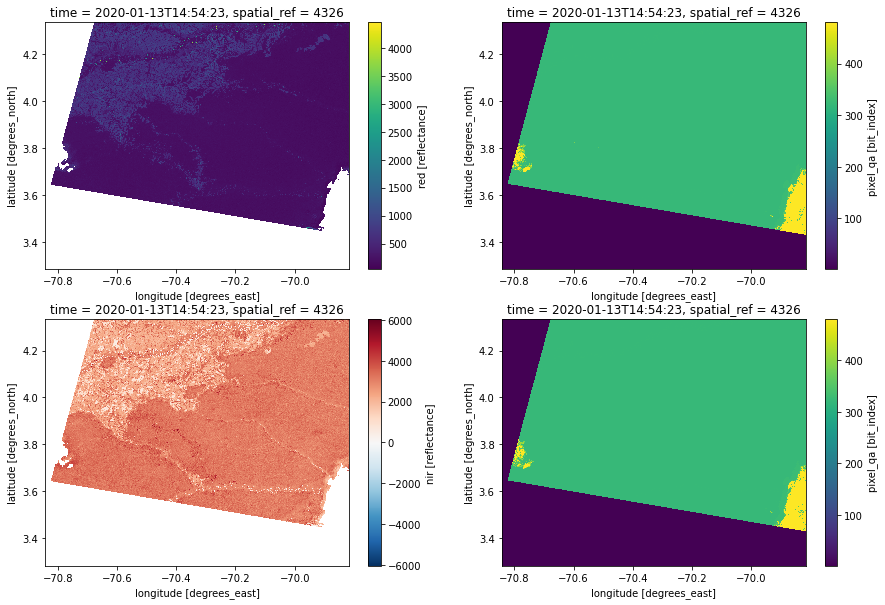

In [4]:
%%time 

dataset.red.values = cloud_mask(dataset.red,dataset.pixel_qa)
dataset.nir.values = cloud_mask(dataset.nir,dataset.pixel_qa)

plt.figure(figsize=(400,600))
fig, axes = plt.subplots(2,2,figsize=(15,10))
# plt.tight_layout()

dataset.red.plot(ax=axes[0][0])
dataset.pixel_qa.plot(ax=axes[0][1])
dataset.nir.plot(ax=axes[1][0])
dataset.pixel_qa.plot(ax=axes[1][1])

## NDVI Calculation 

In [7]:
def ndvi(red,nir):
    """Indice de Vegetación Normalizado.
    
    Args:
        red (xarray.DataArray): Banda red .
        nir (xarray.DataArray): Banda nir.
        
    Returns:
        xarray.DataArray: Matr
    """
    # Obteniendo los valores de las bandas. 
    # los valores son np.array
    period_red = red.values
    period_nir = nir.values

    # Si los pixeles en 'red' o 'nir' tiene valoes NaN entonces 
    # mask_nan = True
    mask_nan=np.logical_or(np.isnan(period_red), np.isnan(period_nir))

    # NDVI computation
    period_nvdi = (period_nir-period_red) / (period_nir+period_red)

    # Remover pixeles invalidos
    period_nvdi[mask_nan] = np.nan

    # Remover valores mayores de 1 e inferiores a -1
    # Ya que el indice está definido entre -1 y 1.
    period_nvdi[period_nvdi>1] = np.nan
    period_nvdi[period_nvdi<-1] = np.nan

    data_array = xr.DataArray(data=period_nvdi)
    return data_array

NDVI calculation

In [5]:
%%time

mask_nan=np.logical_or(np.isnan(dataset.red.values), np.isnan(dataset.nir.values))

dataset['ndvi'] = (dataset.nir-dataset.red) / (dataset.nir+dataset.red)
dataset['ndvi'].values[mask_nan] = np.nan

dataset.ndvi.values[dataset.ndvi.values>1] = np.nan
dataset.ndvi.values[dataset.ndvi.values<-1] = np.nan

plt.figure(figsize=(400,600))
fig, axes = plt.subplots(1,figsize=(15,10))
# plt.tight_layout()

dataset.ndvi.plot(ax=axes)

AttributeError: 'Dataset' object has no attribute 'ndvi'